# Model collaboration example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from joblib import load

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

In [2]:
def build_model(**params):
    
    # List of parameters
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=(92,5,), return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    if 'full_prediction' in params and params['full_prediction']:
        model.add(Dense(5, activation='linear'))
    else:
        model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    return model

In [3]:
model1 = {'lstmsize': 162,
          'twice': True,
          'shuffle': True,
          'optimizer': 'adam',
          'activation': 'elu',
          'density': 188,
          'full_density': True}

model2 = {'density': 238,
          'twice': True,
          'optimizer': 'adam',
          'dropout': 0.1,
          'activation': 'elu',
          'full_density': True,
          'shuffle': True,
          'lstmsize': 176}

model3 = {'shuffle': True,
          'dropout': 0.1,
          'lstmsize': 160,
          'activation': 'relu',
          'twice': False,
          'optimizer': 'adam',
          'density': 122}

model4 = {'density': 138,
          'shuffle': True,
          'full_density': True,
          'twice': False,
          'activation': 'relu',
          'optimizer': 'adam',
          'lstmsize': 92}

model5 = {'activation': 'softsign',
          'shuffle': True,
          'lstmsize': 104,
          'full_density': True,
          'twice': False,
          'optimizer': 'adam',
          'density': 180}

modelfull = {'lstmsize': 94,
             'optimizer': 'adamax',
             'shuffle': True,
             'density': 140,
             'twice': False,
             'activation': 'relu',
             'full_prediction': True}

In [4]:
model1 = build_model(**model1)
model2 = build_model(**model2)
model3 = build_model(**model3)
model4 = build_model(**model4)
model5 = build_model(**model5)
modelfull = build_model(**modelfull)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
model1.load_weights('./checkpoints/IBM_MSE/IBM.(best).hdf5')
model2.load_weights('./checkpoints/IBM_2days/IBM.(best).hdf5')
model3.load_weights('./checkpoints/IBM_3days/IBM.(best).hdf5')
model4.load_weights('./checkpoints/IBM_4days/IBM.(best).hdf5')
model5.load_weights('./checkpoints/IBM_5days/IBM.(best).hdf5')
modelfull.load_weights('./checkpoints/IBMFULL_MSE/IBM.(best).hdf5')

##### I load the data and try to do some predictions over periods of 5 days usign the 5 previous models

In [6]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')
data = data.drop(columns='date')

# Sequence for the LSTM network
backlook = 92

# Load normalisers
normaliser = load('./normalisers/x_normaliser.joblib')
y_normaliser = load('./normalisers/y_normaliser.joblib')

# Normalise data
data_norm = normaliser.transform(data)

# Y raw data
next_day_open_values = np.array([data.to_numpy()[:,3][i + backlook] for i in range(len(data) - backlook)])
next_day_open_values = np.expand_dims(next_day_open_values, -1)

# Y normaliser
y_normaliser.transform(next_day_open_values)

array([[0.33316742],
       [0.32308841],
       [0.33553164],
       ...,
       [0.43999253],
       [0.44260561],
       [0.43178   ]])

In [7]:
for i in np.arange(0,30,1):
    if i == 0:
        day1_sequence = np.array([data_norm[-(backlook):].copy()])
    else:
        day1_sequence = np.array([data_norm[-(backlook+i):-i].copy()])
        
    day2index = np.arange(len(data)+1-i-(backlook*2), len(data)-i, 2)
    day3index = np.arange(len(data)+2-i-(backlook*3), len(data)-i, 3)
    day4index = np.arange(len(data)+3-i-(backlook*4), len(data)-i, 4)
    day5index = np.arange(len(data)+4-i-(backlook*5), len(data)-i, 5)
    
    day2_sequence = np.array([data_norm[day2index].copy()])
    day3_sequence = np.array([data_norm[day3index].copy()])
    day4_sequence = np.array([data_norm[day4index].copy()])
    day5_sequence = np.array([data_norm[day5index].copy()])
    
    if i == 0:
        prediction = np.array([y_normaliser.inverse_transform(model1.predict(day1_sequence)),
                               y_normaliser.inverse_transform(model2.predict(day2_sequence)),
                               y_normaliser.inverse_transform(model3.predict(day3_sequence)),
                               y_normaliser.inverse_transform(model4.predict(day4_sequence)),
                               y_normaliser.inverse_transform(model5.predict(day5_sequence))]).reshape(1,5)
        
        test_data = np.array([data.to_numpy()[-5:,0]]).reshape(1,5)
        
    else:
        prediction = np.append(np.array([y_normaliser.inverse_transform(model1.predict(day1_sequence)),
                                         y_normaliser.inverse_transform(model2.predict(day2_sequence)),
                                         y_normaliser.inverse_transform(model3.predict(day3_sequence)),
                                         y_normaliser.inverse_transform(model4.predict(day4_sequence)),
                                         y_normaliser.inverse_transform(model5.predict(day5_sequence))]).reshape(1,5),
                               prediction, axis=0)
        
        test_data = np.append(np.array([data.to_numpy()[-5-i:-i,0]]).reshape(1,5), test_data, axis=0)

In [8]:
days = 10

subset = np.array([data_norm[-backlook:]])
predicted = np.array(modelfull.predict(subset))

for i in range(days-1):
    subset = np.append(subset[:,1:], np.array([[predicted[-1]]]), axis=1)
    predicted = np.append(predicted, modelfull.predict(subset), axis=0)
    
predicted = normaliser.inverse_transform(predicted)

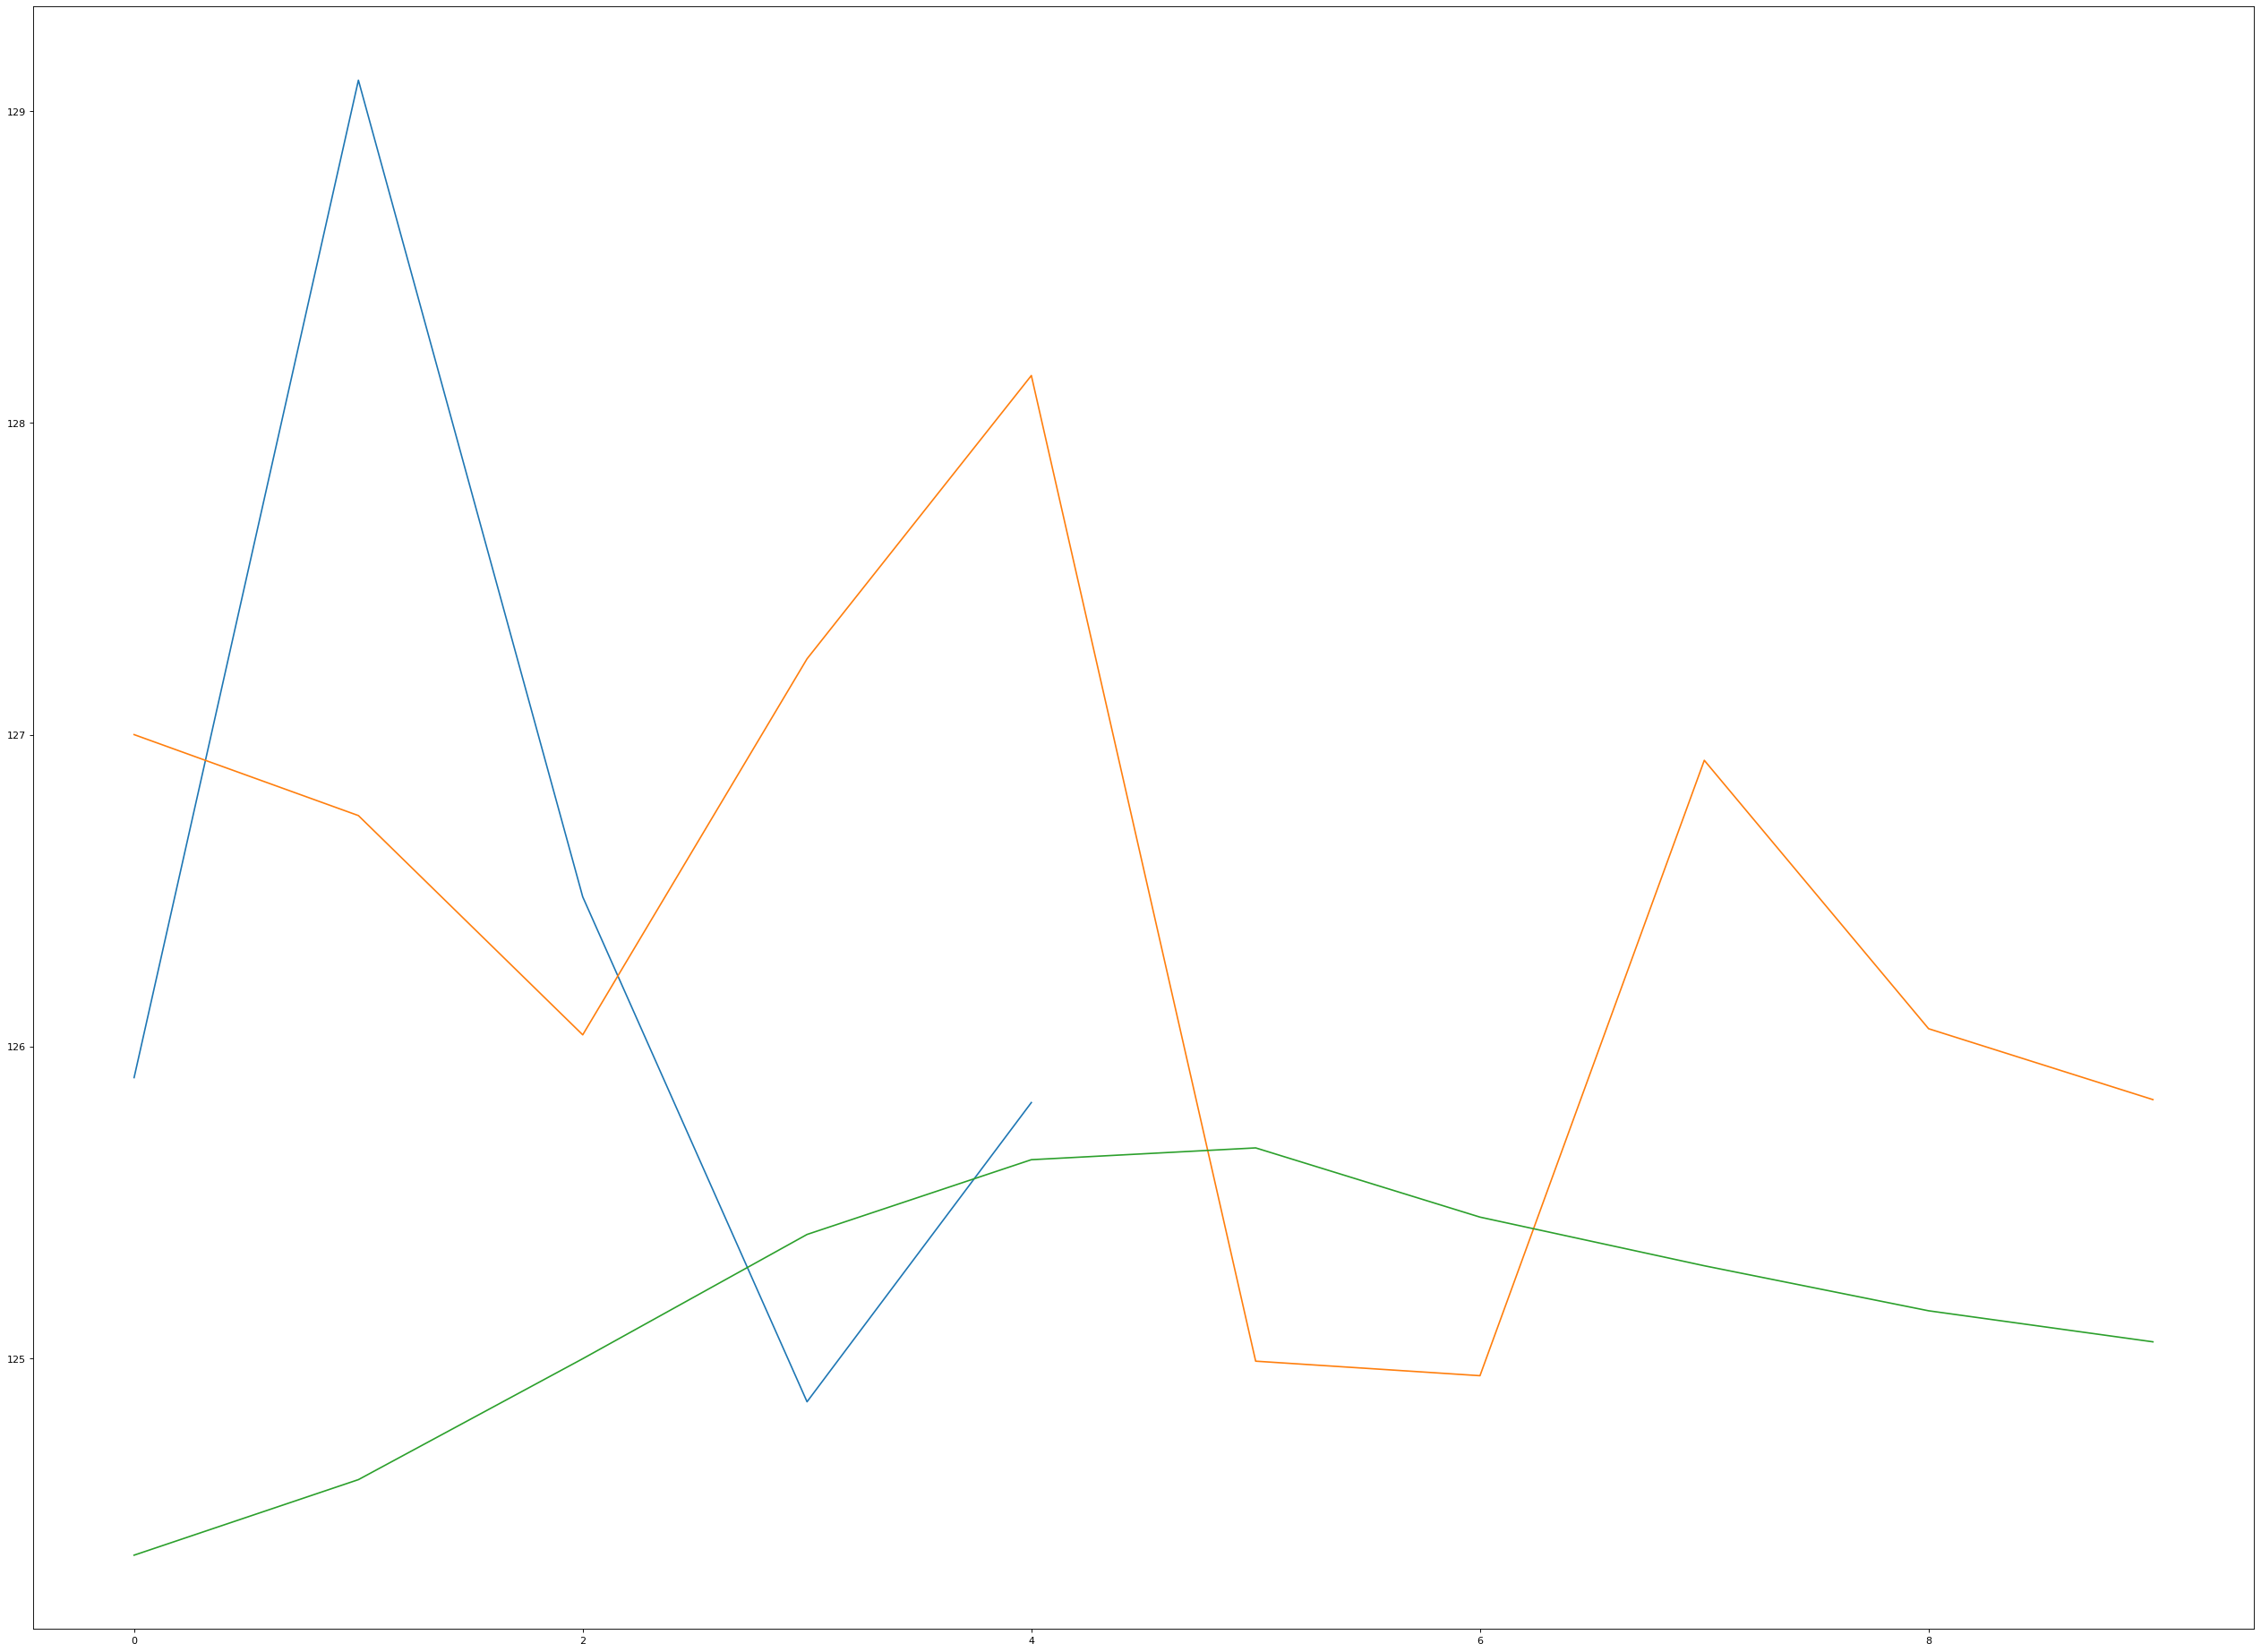

In [9]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(5), test_data[-1])
plt.plot(range(10), np.append(prediction[-6], prediction[-1]))
plt.plot(range(10), predicted[:,3])
plt.plot()
plt.show()

In [10]:
days = 15

subset = np.array([data_norm[-backlook:]])
predicted = np.array(modelfull.predict(subset))

for i in range(days-1):
    subset = np.append(subset[:,1:], np.array([[predicted[-1]]]), axis=1)
    predicted = np.append(predicted, modelfull.predict(subset), axis=0)
    
predicted = normaliser.inverse_transform(predicted)

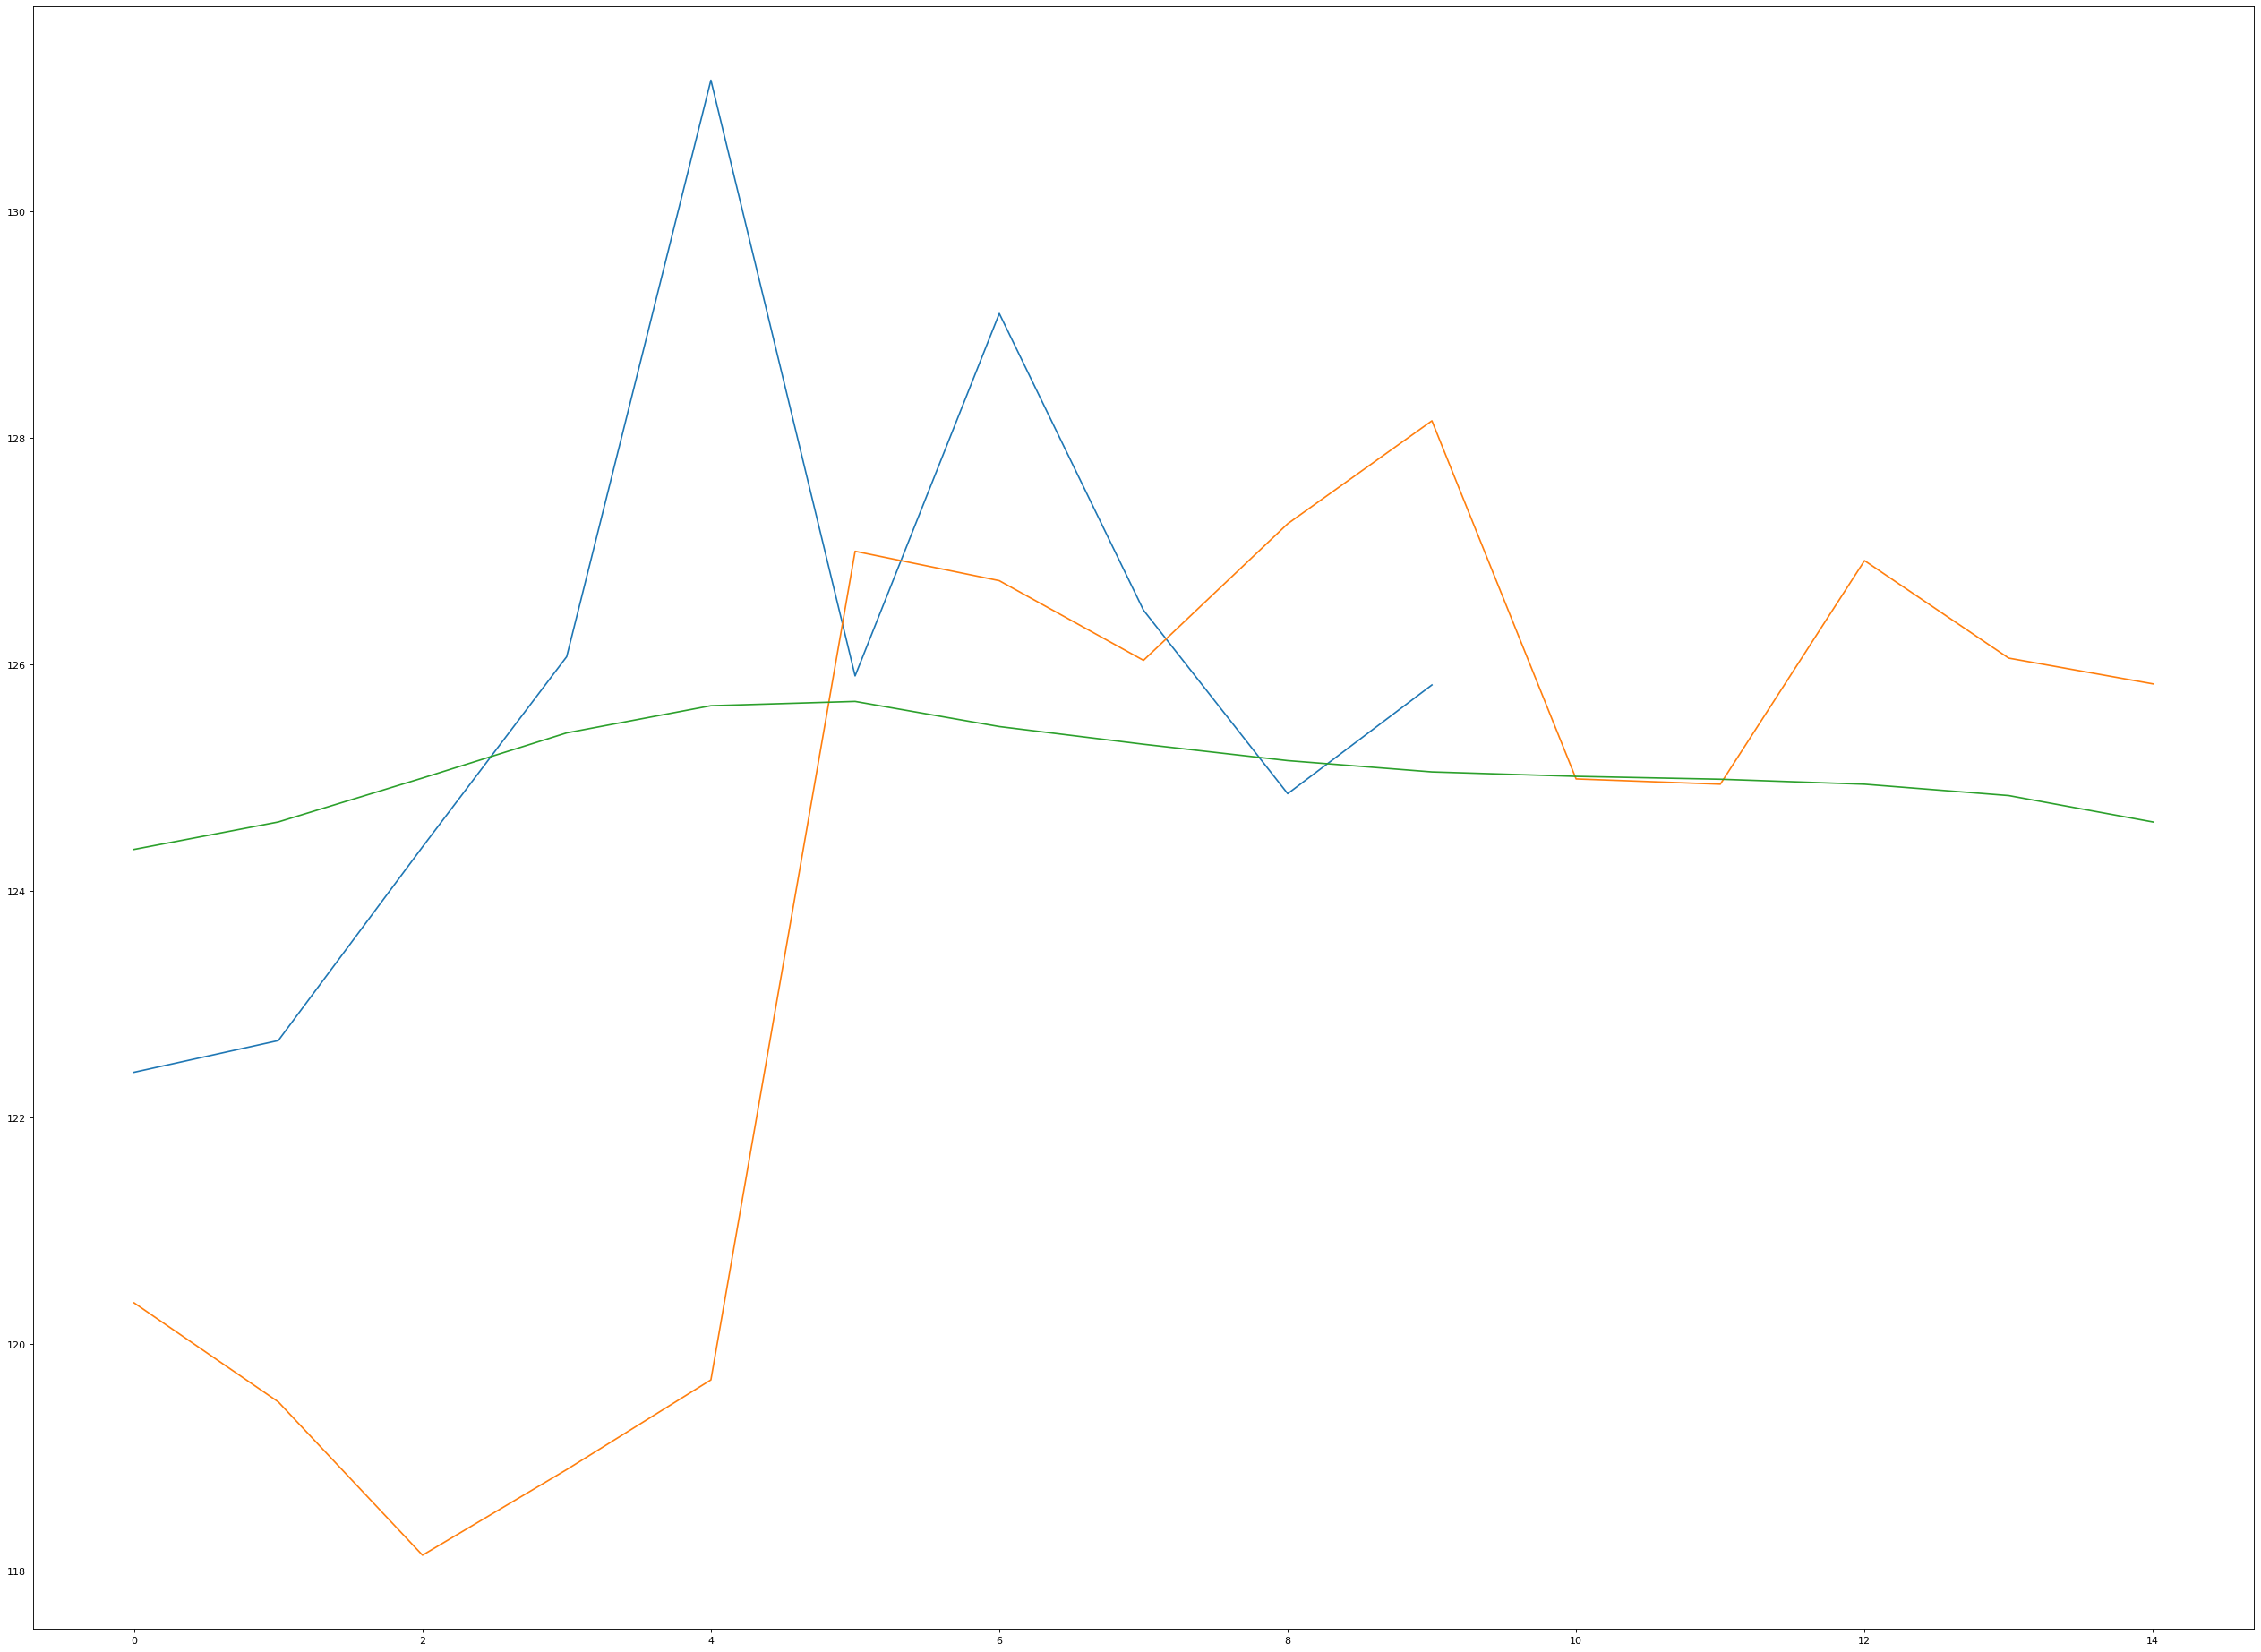

In [11]:
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(10), np.append(test_data[-6], test_data[-1]))
plt.plot(range(15), np.append(prediction[-11], np.append(prediction[-6], prediction[-1])))
plt.plot(range(15), predicted[:,3])
plt.show()